# Assignment 3

### Objective
The objectives of this assignment are to familiarize the students with the datasets
used in the Earth System Sciences and their processing and manipulation by the available tools. By the end of this tutorial, the students should be able to spatially and temporally average the variables from a gridded (latitude, longitude, and time) dataset to create a spatial subset and time series at a given location. They will also learn about computing the statistical measures and
comparing between different datasets.

### Instructions
This assignment is accompanied by the necessary datasets; one netCDF or .nc
and four .csv files.

### 1. Required Information

| Site Name | Latitude (°N) | Longitude (°E) |
|-----------|---------------|-----------------|
| KIT       | 13.02         | 77.57           |
| JIT       | 26.99         | 71.34           |
| OIT       | 20.15         | 85.68           |
| UIT       | 26.51         | 80.22           |


### 2. Open the .nc file. Note down the file dimensions (latitude, longitude, and time) and resolutions (spatial and temporal), and variable name and unit.

In [1]:
import warnings

# Ignore the RuntimeWarnings
warnings.filterwarnings("ignore", message="numpy.ndarray size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#Importing the required libraries
import netCDF4 as nc
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt



In [2]:
nc_file = nc.Dataset('GPP_India_2013_FC.nc')

In [3]:
#Extracting dimensions
longitude_dim = nc_file.dimensions['lon'].size
latitude_dim = nc_file.dimensions['lat'].size
time_dim = nc_file.dimensions['time'].size

#Extracting Temporal Resolution
temporal_res = nc_file.temporal_resolution

#Extracting Spatial Resolution
latitude_resolution = abs(nc_file['lat'][1] - nc_file['lat'][0])
longitude_resolution = abs(nc_file['lon'][1] - nc_file['lon'][0])

#Extracting variables
vars = list(nc_file.variables.keys())[-1]
vars_unit = nc_file.variables[vars].units

#Printing the Information
print(f"Title: {nc_file.title}")
print(f"File Dimensions: Latitude-{latitude_dim}, Longitude-{longitude_dim}, Time-{time_dim}")
print(f"Temporal Resolution: {temporal_res}")
print(f"Spatial Resolution: Latitude-{latitude_resolution}, Longitude-{longitude_resolution}")
print(f"Variable: Name-{vars}, Unit-{vars_unit}")


Title: GPP based on FLUXCOM RS+METEO with CRUNCEPv6 climate 
File Dimensions: Latitude-78, Longitude-68, Time-365
Temporal Resolution: daily
Spatial Resolution: Latitude-0.5, Longitude-0.5
Variable: Name-GPP, Unit-gC m-2 day-1


### 3. Take the annual mean of the GPP variable and make a plot (spatial map).

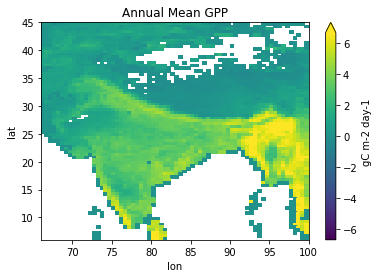

In [4]:
ds = xr.open_dataset('GPP_India_2013_FC.nc')

#Calculating Annual Mean of GPP variable
annual_mean_gpp = ds['GPP'].resample(time='1Y').mean(dim='time')

#Plotting the Spatial Map
annual_mean_gpp.plot(x='lon', y='lat', robust=True, cmap='viridis', cbar_kwargs={
                     'label': f'{ds["GPP"].units}'})
plt.title(f'Annual Mean GPP')
plt.show()


### 4. Subset the .nc file for smaller domains for each of the sites listed in Step 1. Take 1° by 1° boxes centered around the site locations for this purpose. Save the four subset files in .nc format.

In [5]:
# Define site information
sites = {
    'KIT': {'lat': 13.02, 'lon': 77.57},
    'JIT': {'lat': 26.99, 'lon': 71.34},
    'OIT': {'lat': 20.15, 'lon': 85.68},
    'UIT': {'lat': 26.51, 'lon': 80.22}
}

# Setting size of box
box_size = 1.0


In [6]:


# Subsetting and saving the file
for site_name, site_info in sites.items():
    # Calculating latitude and longitude boundaries for each subset
    lat_min = site_info['lat'] - 0.5 * box_size
    lat_max = site_info['lat'] + 0.5 * box_size
    lon_min = site_info['lon'] - 0.5 * box_size
    lon_max = site_info['lon'] + 0.5 * box_size

    # Subsetting the data
    subset = ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))

    # Convert 'time' variable to datetime format
    subset['time'] = pd.to_datetime(subset['time'].values)

    # Set the datetime format in the xarray dataset
    subset = subset.assign_coords(time=subset['time'].values)

    # Saving the subset to a new .nc file
    subset_file_path = f'{site_name}_subset.nc'

    subset.to_netcdf(subset_file_path, format='NETCDF4')

    print(f"Subset for {site_name} saved to {subset_file_path}")


Subset for KIT saved to KIT_subset.nc
Subset for JIT saved to JIT_subset.nc
Subset for OIT saved to OIT_subset.nc
Subset for UIT saved to UIT_subset.nc


In [7]:
ds1 = xr.open_dataset('KIT_subset.nc')
print(ds1['GPP'])
ds1.close()

<xarray.DataArray 'GPP' (time: 365, lat: 2, lon: 2)>
array([[[0.858831, 0.890355],
        [1.243872, 1.164436]],

       [[0.883758, 0.90466 ],
        [1.259256, 1.140027]],

       ...,

       [[1.154006, 1.235418],
        [1.445069, 1.360862]],

       [[1.133978, 1.2049  ],
        [1.454339, 1.346747]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 77.25 77.75
  * lat      (lat) float64 13.25 12.75
  * time     (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
Attributes:
    long_name:  GPP
    units:      gC m-2 day-1


### 5. Using these subset .nc files, compute the mean of the GPP variable over the grid (the 1° by 1° boxes created in the last step). This should create a time series of GPP for each location.

In [8]:
# Empty dictionary to store time series of GPP for each location
gpp_time_series = {}

for site_name, site_info in sites.items():
    subset_file_path = f'{site_name}_subset.nc'

    with nc.Dataset(subset_file_path, 'r') as subset_nc:
        lat = subset_nc.variables['lat'][:]
        lon = subset_nc.variables['lon'][:]
        time = subset_nc.variables['time'][:]
        gpp_data = subset_nc.variables['GPP'][:]

    # Creating xarray dataset from the loaded data
    subset_ds = xr.Dataset(
        {'GPP': (['time', 'lat', 'lon'], gpp_data)},
        coords={'lat': lat, 'lon': lon, 'time': time}
    )

    # Compute the mean of the GPP variable over the grid
    gpp_mean = subset_ds['GPP'].mean(dim=('lat', 'lon'))

    # Store the time series in the dictionary
    gpp_time_series[site_name] = gpp_mean

    #Print Acknowledgement
    print(f"Time series for {site_name} saved to gpp_time_series")


Time series for KIT saved to gpp_time_series
Time series for JIT saved to gpp_time_series
Time series for OIT saved to gpp_time_series
Time series for UIT saved to gpp_time_series


In [9]:
gpp_time_series['KIT']

<xarray.DataArray 'GPP' (time: 365)>
array([1.0393732 , 1.0469252 , 1.014359  , 1.002927  , 1.0283316 ,
       0.9839076 , 0.9866766 , 0.9546976 , 0.9799124 , 1.0025853 ,
       1.0068572 , 0.99818194, 1.027778  , 0.9756701 , 0.9608509 ,
       0.94271624, 0.93037426, 0.9368115 , 0.9279367 , 0.906215  ,
       0.89156675, 0.9135817 , 0.86437345, 0.86511856, 0.86383486,
       0.8676778 , 0.8596487 , 0.84977496, 0.80660325, 0.8301644 ,
       0.87608826, 0.8230233 , 0.84615546, 0.8523591 , 0.8604834 ,
       0.8215362 , 0.8085706 , 0.82237685, 0.7759801 , 0.7643026 ,
       0.7900889 , 0.7928712 , 0.82963586, 0.8326529 , 0.78466535,
       0.7066722 , 0.7335276 , 0.79140353, 0.7825647 , 0.80501306,
       0.86860305, 0.8634506 , 0.88849777, 0.91045284, 0.9410036 ,
       0.9802269 , 0.97251177, 0.9447639 , 0.9463244 , 0.98945284,
       0.98753005, 0.99882483, 1.002738  , 0.9365679 , 0.9682157 ,
       1.0023832 , 0.99452007, 1.0008805 , 1.0354184 , 1.0191107 ,
       1.0227246 , 1.0117784 , 1.0148995 , 1.0261321 , 1.0225381 ,
       1.08281   , 1.0728567 , 1.0674744 , 1.0298433 , 1.1318944 ,
       1.1990736 , 1.142978  , 1.1532663 , 1.1395984 , 1.1796818 ,
       1.213137  , 1.2344987 , 1.2196593 , 1.201079  , 1.190328  ,
       1.2610364 , 1.2152022 , 1.2636261 , 1.3357643 , 1.3708702 ,
       1.3221338 , 1.3201548 , 1.3266988 , 1.3241544 , 1.3857179 ,
...
       4.870579  , 4.84035   , 4.7271504 , 4.7062597 , 4.613665  ,
       4.5589824 , 4.628929  , 4.6566095 , 4.4734473 , 4.3785224 ,
       4.3104286 , 4.2952337 , 4.2237663 , 4.1067195 , 4.022059  ,
       3.9724243 , 4.0701776 , 3.855626  , 3.6374452 , 3.6628208 ,
       3.6622815 , 3.6216502 , 3.6894064 , 3.6651073 , 3.6019058 ,
       3.6290076 , 3.6602464 , 3.6588807 , 3.7217002 , 3.8281665 ,
       3.992391  , 4.132107  , 4.122661  , 3.9842606 , 4.105172  ,
       4.2618074 , 4.245791  , 4.2523026 , 4.307056  , 4.2181435 ,
       4.0812855 , 3.9515407 , 3.830658  , 3.726394  , 3.5862157 ,
       3.4268885 , 3.320165  , 3.2481642 , 3.1675708 , 3.1675873 ,
       3.3172743 , 3.4289827 , 3.490623  , 3.431606  , 3.3337297 ,
       3.1389625 , 3.1393456 , 3.3358374 , 3.366013  , 3.4650288 ,
       3.4451728 , 3.3637342 , 3.2371466 , 3.099485  , 2.9008179 ,
       2.754057  , 2.6529055 , 2.6167765 , 2.5683477 , 2.5438051 ,
       2.4403563 , 2.248139  , 2.3118062 , 2.2658138 , 2.167405  ,
       2.0248098 , 1.9087956 , 1.9155405 , 1.9227735 , 1.9052632 ,
       1.874645  , 1.8079399 , 1.7284005 , 1.6723692 , 1.6350064 ,
       1.5901679 , 1.5460637 , 1.4971123 , 1.4597014 , 1.435648  ,
       1.4104366 , 1.365247  , 1.3018425 , 1.2988386 , 1.2849909 ],
      dtype=float32)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363 364

### 6. The .csv files also contain the GPP records at each of these sites. Check the unit and temporal resolution of GPP in these files.

In [10]:
for site_name in sites.keys():
    #Setting filepath
    filepath = f'{site_name}_regional_GPP_MODIS_processed.csv'
    #Reading csv file
    df = pd.read_csv(filepath)
    #Changing unit of GPP
    df['GPP (gC m-2)'] = df['GPP (kgC m-2)'] * 1000/8
    #Dropping the column
    df.drop(columns=['GPP (kgC m-2)'], inplace=True)
    #Printing sample of the data
    print(f"Sample of {filepath}")
    print(df.tail())
    print('*'*100)


Sample of KIT_regional_GPP_MODIS_processed.csv
      DateTime  GPP (gC m-2)
41  2013-11-25      3.110205
42  2013-12-03      3.558399
43  2013-12-11      2.829602
44  2013-12-19      3.340214
45  2013-12-27      1.855254
****************************************************************************************************
Sample of JIT_regional_GPP_MODIS_processed.csv
      DateTime  GPP (gC m-2)
41  2013-11-25      0.355430
42  2013-12-03      0.461578
43  2013-12-11      0.590638
44  2013-12-19      0.858683
45  2013-12-27      0.437359
****************************************************************************************************
Sample of OIT_regional_GPP_MODIS_processed.csv
      DateTime  GPP (gC m-2)
41  2013-11-25      3.196981
42  2013-12-03      2.870119
43  2013-12-11      2.616731
44  2013-12-19      2.432605
45  2013-12-27      1.407480
****************************************************************************************************
Sample of UIT_regional_GPP_MODIS_p

In [11]:
print(f"The unit of GPP in csv files is:- {df.columns[1][4:]}")
print("The temporal resolution is 8 days")


The unit of GPP in csv files is:- (gC m-2)
The temporal resolution is 8 days


### 7. For each of the sites, plot both the time series (created in Step 5 and given in .csv files) and compare. You might need to do a temporal averaging to do so. Check the temporal resolution of the .csv files carefully.

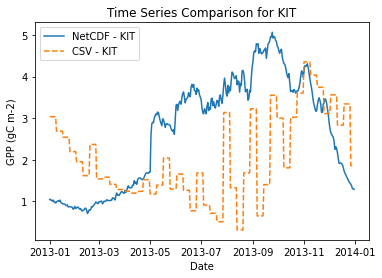

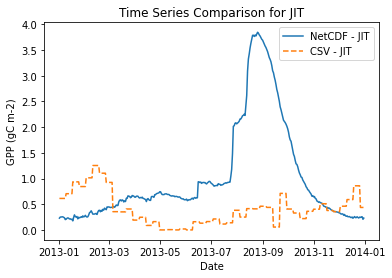

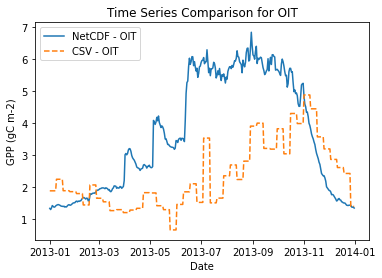

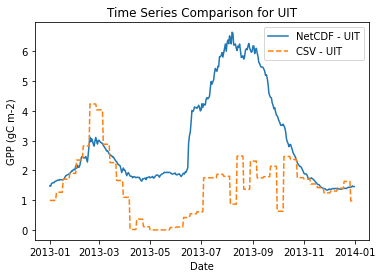

In [12]:
csv_time_series = {}

for site_name in sites.keys():
    # Setting filepath
    filepath = f'{site_name}_regional_GPP_MODIS_processed.csv'
    # Reading csv file
    df = pd.read_csv(filepath)

    df['GPP (gC m-2)'] = df['GPP (kgC m-2)'] * 1000/8

    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index('DateTime', inplace=True)

    # Resample with forward fill (ffill) for missing values
    df = df.resample('D').ffill()

    # Reset the index if needed
    df.reset_index(inplace=True)

    l1 = list(df[df['DateTime'] == '2013-12-27']['GPP (gC m-2)'].values)*4
    
    missing_dates = pd.date_range(start='2013-12-28', end='2013-12-31')
    missing_df = pd.DataFrame(
        {'DateTime': missing_dates, 'GPP (gC m-2)': l1})
    df = pd.concat([df, missing_df]).sort_values('DateTime')


    csv_time_series[site_name] = df.set_index('DateTime')['GPP (gC m-2)']

for site_name, gpp_series in gpp_time_series.items():
    # Plot time series from NetCDF files
    csv_series = csv_time_series[site_name]
    plt.plot(csv_series.index, gpp_series,
             label=f'NetCDF - {site_name}')

    # Plot time series from CSV files
    
    plt.plot(csv_series.index, csv_series,
             label=f'CSV - {site_name}', linestyle='dashed')

    plt.xlabel('Date')
    plt.ylabel('GPP (gC m-2)')
    plt.title(f'Time Series Comparison for {site_name}')
    plt.legend()
    plt.show()




### 8. Make scatter plots between both these sets of GPPs for each site.

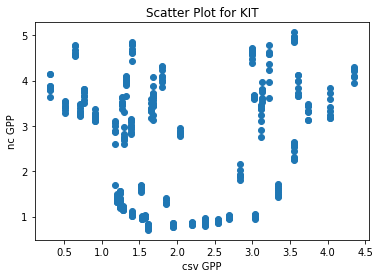

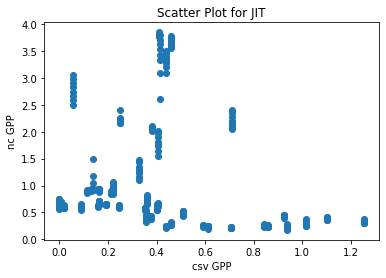

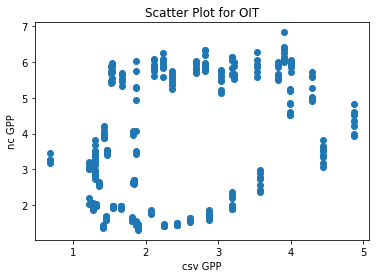

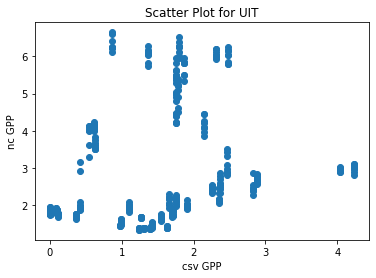

In [13]:
for site_name, gpp_series in gpp_time_series.items():
    csv_series = csv_time_series[site_name]
    plt.scatter(csv_series, gpp_series)

    plt.xlabel('csv GPP')
    plt.ylabel('nc GPP')
    plt.title(f'Scatter Plot for {site_name}')
    plt.show()


### 9. Compute mean, median, mode, standard deviation, kurtosis, and skewness for all these GPP datasets (i.e. created in Step 5 and given in .csv files), at all the four sites.

In [14]:
from scipy.stats import mode, skew, kurtosis

In [15]:
def compute_stats(series):
    mean_value = series.mean()
    median_value = series.median()
    mode_value = mode(series)[0][0]
    std_value = series.std()
    skew_value = skew(series)
    kurtosis_value = kurtosis(series)

    if isinstance(mean_value, xr.DataArray):
        mean_value = mean_value.values.item()
    if isinstance(median_value, xr.DataArray):
        median_value = median_value.values.item()
    if isinstance(std_value, xr.DataArray):
        std_value = std_value.values.item()

    return {
        'mean': round(mean_value,4),
        'median': round(median_value,4),
        'mode': round(mode_value,4),
        'std': round(std_value,4),
        'skew': round(skew_value,4),
        'kurtosis': round(kurtosis_value,4)
    }

In [16]:
for site_name,gpp_series in gpp_time_series.items():
    csv_series = csv_time_series[site_name]
    nc_series = gpp_series

    csv_stats = compute_stats(csv_series)
    nc_stats = compute_stats(nc_series)

    print(f"Statistics for {site_name}")
    print(f"CSV: {csv_stats}")
    print(f"NetCDF: {nc_stats}")
    print('*'*100)

Statistics for KIT
CSV: {'mean': 2.0513, 'median': 1.6812, 'mode': 0.3099, 'std': 1.0329, 'skew': 0.4342, 'kurtosis': -0.8947}
NetCDF: {'mean': 2.6921, 'median': 3.1049, 'mode': 0.7067, 'std': 1.3225, 'skew': -0.113, 'kurtosis': -1.4145}
****************************************************************************************************
Statistics for JIT
CSV: {'mean': 0.4034, 'median': 0.3625, 'mode': 0.0, 'std': 0.3118, 'skew': 0.8738, 'kurtosis': 0.1261}
NetCDF: {'mean': 1.0134, 'median': 0.6384, 'mode': 0.1762, 'std': 0.9764, 'skew': 1.6966, 'kurtosis': 1.7241}
****************************************************************************************************
Statistics for OIT
CSV: {'mean': 2.3694, 'median': 2.0741, 'mode': 0.6729, 'std': 1.0297, 'skew': 0.6862, 'kurtosis': -0.5755}
NetCDF: {'mean': 3.6703, 'median': 3.3969, 'mode': 1.3066, 'std': 1.7828, 'skew': 0.1246, 'kurtosis': -1.6172}
*****************************************************************************************

### 10. Plot histogram of these GPP datasets (i.e. created in Step 5 and given in .csv files) at all the four sites.

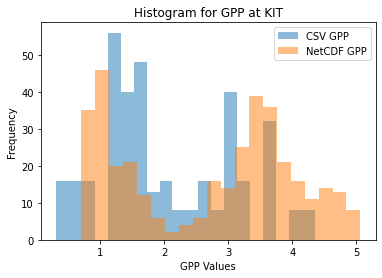

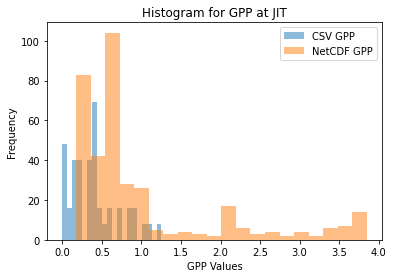

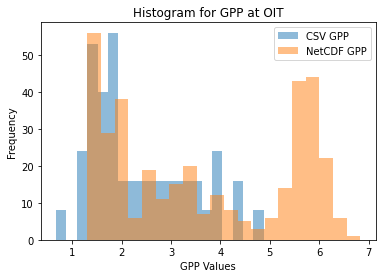

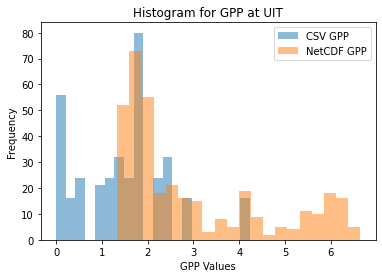

In [17]:
for site_name in gpp_time_series.keys():
    # Extract GPP series from CSV and NetCDF datasets
    csv_series = csv_time_series[site_name]
    nc_series = gpp_time_series[site_name]

    # Plotting histograms
    plt.hist(csv_series, bins=20, alpha=0.5, label='CSV GPP')
    plt.hist(nc_series, bins=20, alpha=0.5, label='NetCDF GPP')

    plt.xlabel('GPP Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram for GPP at {site_name}')
    plt.legend()
    plt.show()
